In [4]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import torch
from torch import nn
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sparse_causal_model_learner_rl.learners import rl_learner
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
import gin
import ray
import pickle
from causal_util.helpers import CPU_Unpickler, lstdct2dctlst
gin.enter_interactive_mode()

from copsolver.frank_wolfe_solver import FrankWolfeSolver
from commondescentvector.multi_objective_cdv import MultiObjectiveCDV

In [5]:
load_config_files(['../vectorincrement/config/ve5_toy_digits.gin',
                   '../sparse_causal_model_learner_rl/configs/ve5_digits_rec.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect_big.gin'])

['ve5_toy_digits', 've5_digits_rec', 'server_collect_big']

In [6]:
gin.bind_parameter('Config.load_new_config', True)
gin.bind_parameter('Config.load_checkpoint', '/home/sergei/ray_results/ve5_toy_digits_ve5_digits_rec_server_collect_big/main_fcn_98f13_00000_0_2021-02-20_08-59-46/checkpoint_5000/')

In [7]:
ray.init('10.90.40.13:6379')

2021-02-20 11:14:27,824	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.40.13:6379


{'node_ip_address': '10.90.40.13',
 'raylet_ip_address': '10.90.40.13',
 'redis_address': '10.90.40.13:6379',
 'object_store_address': '/tmp/ray/session_2021-02-20_08-11-18_390441_20021/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-20_08-11-18_390441_20021/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-20_08-11-18_390441_20021',
 'metrics_export_port': 38990,
 'node_id': '54ef4680490a04e32abf625d1245b34633c06d30'}

In [8]:
f = open(gin.query_parameter('Config.load_checkpoint') + '/checkpoint', 'rb')
#l = CPU_Unpickler(f).load()
l = pickle.load(f)

2021-02-20 11:14:30,940	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 6bf8241c-7364-11eb-927a-90e2baa15230
Make environment VectorIncrement-v0 None {}
(pid=23393) Make environment VectorIncrement-v0 None {}
(pid=23404) Make environment VectorIncrement-v0 None {}
(pid=23432) Make environment VectorIncrement-v0 None {}
(pid=23395) Make environment VectorIncrement-v0 None {}
(pid=23421) Make environment VectorIncrement-v0 None {}
(pid=23398) Make environment VectorIncrement-v0 None {}
(pid=23418) Make environment VectorIncrement-v0 None {}
(pid=23408) Make environment VectorIncrement-v0 None {}
(pid=23429) Make environment VectorIncrement-v0 None {}
(pid=23399) Make environment VectorIncrement-v0 None {}
(pid=23413) Make environment VectorIncrement-v0 None {}
(pid=23394) Make environment VectorIncrement-v0 None {}
(pid=23409) Make environment VectorIncrement-v0 None {}
(pid=23427) Make environment VectorIncrement-v0 None {}
(pid=23456) Make environment VectorIncrement-v0 None {}


  0.24054241 0.         0.24486245 0.6693967  0.24486245 0.
  0.2403824  0.6690767  0.2403824  0.         0.23650236 0.67060673
  0.23650236]
 [0.46840468 0.3109031  0.68477684 0.         0.46550465 0.31456316
  0.6815868  0.         0.4623646  0.31342313 0.68310684 0.
  0.46414465 0.31499314 0.6814168  0.         0.4688147  0.31389314
  0.6823968 ]
 [0.6890569  0.55285555 0.68909687 0.         0.6853769  0.55504555
  0.68543684 0.         0.6865569  0.55826557 0.68657684 0.
  0.6849868  0.55535555 0.68500686 0.         0.68604684 0.5503355
  0.68610686]
 [0.6079061  0.3109031  0.5288253  0.         0.6063561  0.31456316
  0.52446526 0.         0.60479605 0.31342313 0.52379525 0.
  0.6064861  0.31499314 0.52349526 0.         0.6082061  0.31389314
  0.5278753 ]
 [0.22498225 0.6720867  0.24199241 0.         0.22372223 0.6686167
  0.24054241 0.         0.22766228 0.6693767  0.24486245 0.
  0.22443224 0.6690567  0.2403824  0.         0.22094221 0.6705467
  0.23650236]] [[0.42826596 0.46937

ERROR:root:Cannot collect data Use collect_and_get_context



[False, False, False, False]
[26, 100, 50, 10, 1] 10
[False, False, False, False, False]
[95, 128, 64, 64, 64, 1] 8
[False, False, False, False]
[8, 128, 64, 32, 1] 95


In [9]:
def tensor_list_shape(lst):
    return [x.shape for x in lst]

def tensor_list_flatten(lst):
    return torch.cat([x.flatten() for x in lst])

def tensor_list_unflatten(t, shape):
    tensors = []
    used_n = 0
    
    for s in shape:
        curr_n = np.prod([int(t) for t in s])
        
        tensors.append(t[used_n:used_n+curr_n].reshape(s))
        
        used_n += curr_n
    
    return tensors

def aggregate_qcop(losses_vals, grads, loss_keys, execution):
    grad_shape = tensor_list_shape(list(grads.values())[0])
    grads_flat = {key: tensor_list_flatten(val) for key, val in grads.items()}
    solver = FrankWolfeSolver()
    cdv = MultiObjectiveCDV(copsolver=solver)#, max_empirical_losses=[losses_vals[k] for k in loss_keys],
                          #  normalized=True)
    
    alpha_loss, alphas = cdv.get_descent_vector(
        losses=[losses_vals[key] for key in loss_keys],
        gradients=np.array([grads_flat[key].detach().cpu().numpy() for key in loss_keys]))
    
    aggregated_gradient = sum([grads_flat[key] * alphas[i] for i, key in enumerate(loss_keys)]).detach()
    aggregated_gradient_list = tensor_list_unflatten(aggregated_gradient, grad_shape)
    
    return aggregated_gradient_list

def aggregate_sum(losses_vals, grads, loss_keys, execution):
    grad_shape = tensor_list_shape(list(grads.values())[0])
    grads_flat = {key: tensor_list_flatten(val) for key, val in grads.items()}
    
    aggregated_gradient = sum([grads_flat[key] * execution[key][1] for i, key in enumerate(loss_keys)]).detach()
    aggregated_gradient_list = tensor_list_unflatten(aggregated_gradient, grad_shape)
    
    return aggregated_gradient_list

def get_grads():
    grads_now = []
    for p in l.params_for_optimizers['opt1']:
        grads_now.append(p.grad)
    return [x.clone() for x in grads_now]

In [10]:
losses = l.config.get('losses')
execution = {key: (losses[key]['fcn'], losses[key]['coeff']) for key in l.config.get('execution')['opt1']}

In [11]:
np.sum([np.prod(x.shape) for x in l.params_for_optimizers['opt1']])

1408999

In [12]:
tracked = []

In [13]:
for i in tqdm(range(1000)):

    losses_vals = {}
    grads = {}
    loss_keys = sorted(execution.keys())

    ctx = l.collect_and_get_context()
    for key, (loss, coeff) in execution.items():
        loss_local_cache = {}

        l.optimizer_objects['opt1'].zero_grad()

        loss_value = loss(**ctx, loss_local_cache=loss_local_cache)
#         print(key, loss_value['loss'].item())
        loss_value['loss'].backward()
        losses_vals[key] = loss_value['loss'].item()
        grads[key] = get_grads()
    #     l.optimizer_objects['opt1'].zero_grad()
    #     l.optimizer_objects['opt1'].step()

    agg_grads = aggregate_qcop(losses_vals, grads, loss_keys, execution)
#     agg_grads = aggregate_sum(losses_vals, grads, loss_keys, execution)
    for param, grad in zip(l.params_for_optimizers['opt1'], agg_grads):
        param.grad = grad.clone()

    l.optimizer_objects['opt1'].step()
    
    tracked.append(losses_vals)

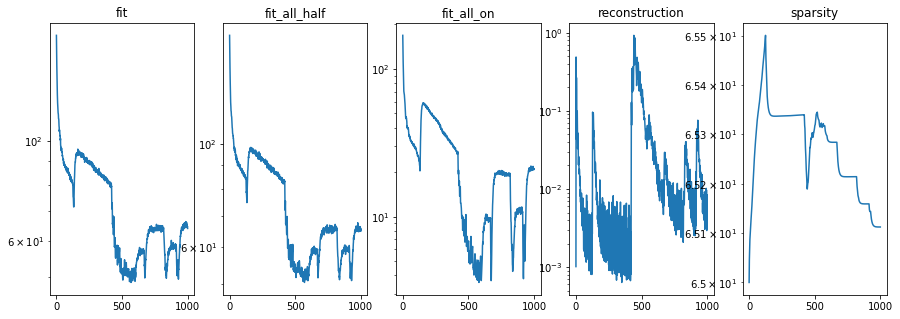

In [14]:
hist = lstdct2dctlst(tracked)
plt.figure(figsize=(15, 5))
for i, key in enumerate(sorted(hist.keys())):
    plt.subplot(1, len(hist), i + 1)
    plt.title(key)
    plt.plot(hist[key])
    plt.yscale('log')
plt.show()

Standard aggregation

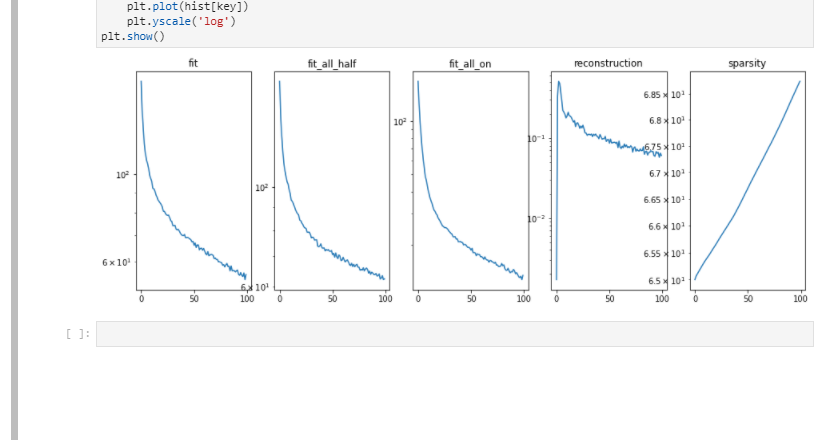

QCOP with no norm

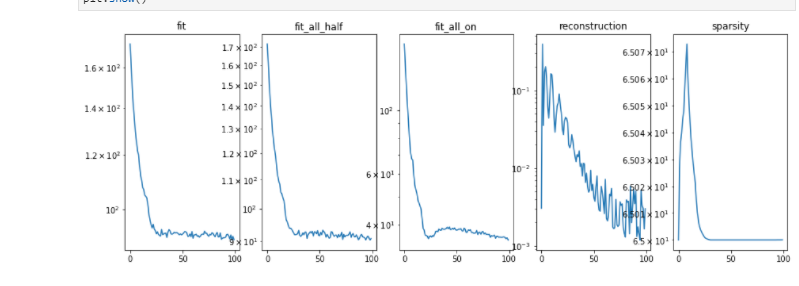

qcop with norm
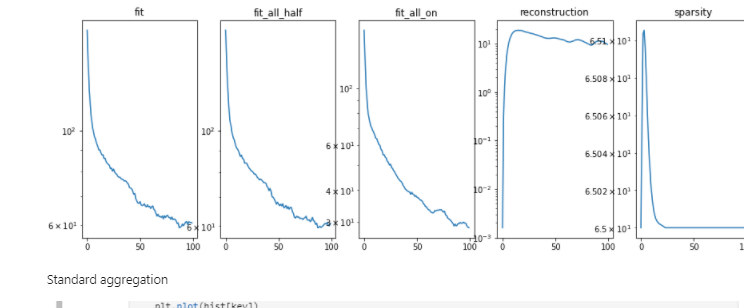

In [26]:
!echo -e "if True:\n\
import os\n\
from setuptools import setup\n\
\n\
setup(\
    name = \"mamo\",\n\
    version = \"0.0.1\",\n\
    author = \"Swisscom\",\n\
    license = \"BSD\",\n\
    packages=['copsolver', 'commondescentvector'],\n\
    classifiers=[\n\
        \"Development Status :: 3 - Alpha\",\n\
        \"Topic :: Utilities\",\n\
        \"License :: OSI Approved :: BSD License\",\n\
    ],\n\
)\n\
"> ../mamo/setup.py
!pip install -e ../mamo/

Obtaining file:///home/sergei/causality-disentanglement-rl/mamo
  Attempting uninstall: mamo
    Found existing installation: mamo 0.0.1
    Uninstalling mamo-0.0.1:
      Successfully uninstalled mamo-0.0.1
  Running setup.py develop for mamo
